In [140]:
import matplotlib.pyplot as plt
import scipy.optimize as spo
import jax.numpy as np
jnp = np
import jax

from my_timer import timer_decorator

# Definice funkcí s jax knihovnou pro možnost automatické derivace (np je nyní z jax.numpy)

In [141]:
def energy_jax(v_internal, fx, v, h, p):
    v = v.at[1:-1].set(v_internal)
    vx = (v[1:] - v[:-1]) / h
    v_mid = (v[1:] + v[:-1]) / 2
    Jv_density = (1 / p) * np.abs(vx)**p - fx * v_mid

    return np.sum(h * Jv_density)


# exact minimizer for p=2
def u_init(x):
    return 0 * (x + 1) * (x - 1)


# rhs
def f(x):
    return -10 * np.ones(x.size)


# úloha stejně jako v pLaPlace_numba

In [142]:
p, a, b = 3, -1, 1
ne = 1000
x = np.linspace(a, b, ne + 1)
h = np.diff(x)

v = u_init(x)            # testing function
v_internal = v[1:-1].copy()
x0 = v_internal.copy()   # initial guess


x_mid = (x[1:] + x[:-1]) / 2
fx = f(x_mid)

# Definování funkce, gradientu a hesiánu; nastavení automatické kompilace jit; vyrobení funce s jedním vstupem

In [143]:
# automatická derivace a kompilace
fun = jax.jit(energy_jax)
dfun = jax.jit(jax.grad(energy_jax, argnums=0))
fun1 = lambda v_internal: fun(v_internal, fx, v, h, p)
dfun1 = lambda v_internal: dfun(v_internal, fx, v, h, p)

# V následujících třech buňkách se s prvním zavoláním funkce rovnou kompiluje jit 

In [144]:
print(f"Initial energy: {fun1(v_internal)}")
print(f"||g||={np.linalg.norm(dfun1(v_internal))}")

Initial energy: 0.0
||g||=0.632139265537262


# solution using laplace approximation of hessian and line search using golden section search

In [145]:
import numpy
def zlatyrez(f, a, b, x, ddd, tol):
    gamma = 1/2 + numpy.sqrt(5)/2
    a0 = a
    b0 = b
    d0 = (b0-a0)/gamma + a0
    c0 = a0 + b0 - d0
    it = 0
    an = a0
    bn = b0
    cn = c0
    dn = d0
    fcn = f(x + cn * ddd)
    fdn = f(x + dn * ddd)

    while bn - an > tol:
        a = an
        b = bn
        c = cn
        d = dn
        fc = fcn
        fd = fdn

        if fc < fd:
            an = a
            bn = d
            dn = c
            cn = an + bn - dn
            fcn = f(x + cn * ddd)
            fdn = fc
        else:
            an = c
            bn = b
            cn = d
            dn = an + bn - cn
            fcn = fd
            fdn = f(x + dn * ddd)

        it += 1

    t = (an + bn) / 2
    return t, it


In [146]:
import numpy
@timer_decorator
def gradient_line_search(f, df, hess_approx_sol, x0, tolf=1e-6, tolg=1e-3, maxit=1000, verbose=False):
    """
    Trust Region (quasi-Newton method)

    Parameters
    ----------
    f : function
        The objective function to be minimized.
    df : function
        The gradient of the objective function.
    hess_approx_sol : function
        Apply the inverse of the approximate Hessian to a vector.
    x0 : numpy.ndarray
        The initial guess for the minimum.
    tolf : float
        The tolerance for the stopping condition for f.
    tolg : float
        The tolerance for the stopping condition for g.
    maxit : int
        The maximum number of iterations.
    verbose : bool
        If True, print the iteration number, the value of f, the size of the
        trust region, and the norm of the gradient.

    Returns
    -------
    xmin : numpy.ndarray
        The found minimum.
    it : int
        The number of iterations.
    """

    x = x0
    it = maxit
    fx = f(x)
    fx_old = -np.inf
    dfx = df(x)
    t0 = 1
    norm_dfx = np.linalg.norm(dfx)
    norm_fx = np.abs(fx - fx_old)
    for i in range(maxit):
        if norm_dfx < tolg:
            it = i
            break
        if norm_fx < tolf:
            it = i
            break
        dfx_laplace = -hess_approx_sol(numpy.array(dfx))
        t, zit = zlatyrez(f,0,t0,x,dfx_laplace,1e-1)
        t0 = t*2
        x = x + t * dfx_laplace
        fx_old = fx
        fx = f(x)
        dfx = df(x)
        norm_dfx = np.linalg.norm(dfx)
        norm_fx = np.abs(fx - fx_old)
        if verbose:
            print(f"it={i}, f={fx}, ||g||={norm_dfx}, , |f - fold|={norm_fx} ,t={t},zit={zit}")

    
    print(f"it={it}, f={fx}, ||g||={norm_dfx}, , |f - fold|={norm_fx}")
    return x, it

In [147]:
import numpy as np
from scipy.sparse import diags
def laplace_1D(x):
    # Calculate distances between nodes
    h = np.diff(x)

    # Initialize diagonals
    main_diag = np.hstack((1, 1/h[:-1] + 1/h[1:], 1))
    lower_diag = np.hstack((0, -1/h[1:]))
    upper_diag = np.hstack((-1/h[:-1], 0))

    # Create the sparse matrix
    laplace_matrix = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1]).tocsc()


    return laplace_matrix[1:-1,1:-1]

In [148]:
from scipy.sparse.linalg import factorized
A = laplace_1D(x)
hess_approx_sol = factorized(A)

In [149]:
resx, it = gradient_line_search(fun1, dfun1, hess_approx_sol, x0, tolf=1e-5, tolg=1e-3, maxit=10000, verbose=True)

it=0, f=-16.219789505004883, ||g||=0.5578626394271851, , |f - fold|=16.219789505004883 ,t=0.3713228931240005,zit=5
it=1, f=-16.740949630737305, ||g||=0.26423609256744385, , |f - fold|=0.5211601257324219 ,t=0.2087970531441898,zit=5
it=2, f=-16.83684539794922, ||g||=0.18484675884246826, , |f - fold|=0.09589576721191406 ,t=0.2697232121573846,zit=3
it=3, f=-16.85620880126953, ||g||=0.11121352761983871, , |f - fold|=0.0193634033203125 ,t=0.21533996640438027,zit=4
it=4, f=-16.862056732177734, ||g||=0.09103614836931229, , |f - fold|=0.005847930908203125 ,t=0.29759251443459306,zit=4
it=5, f=-16.863948822021484, ||g||=0.06916454434394836, , |f - fold|=0.00189208984375 ,t=0.2375900892917858,zit=4
it=6, f=-16.86472511291504, ||g||=0.058553390204906464, , |f - fold|=0.0007762908935546875 ,t=0.28549445803737983,zit=4
it=7, f=-16.865070343017578, ||g||=0.04970771074295044, , |f - fold|=0.0003452301025390625 ,t=0.25975143881536267,zit=4
it=8, f=-16.865243911743164, ||g||=0.04417453706264496, , |f - f

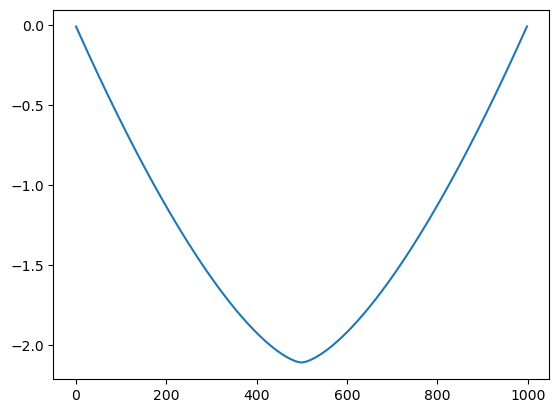

In [150]:
plt.plot(resx)

In [151]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [152]:
%lprun -f gradient_line_search.__wrapped__ -f zlatyrez gradient_line_search(fun1, dfun1, hess_approx_sol, x0, tolf=1e-5, tolg=1e-3, maxit=10000, verbose=False)

it=14, f=-16.86544418334961, ||g||=0.026741022244095802, , |f - fold|=9.5367431640625e-06
gradient_line_search#1: 24.263 ms


Timer unit: 1e-09 s

Total time: 0.0136327 s
File: /tmp/ipykernel_241669/2353539590.py
Function: zlatyrez at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def zlatyrez(f, a, b, x, ddd, tol):
     3        14     216199.0  15442.8      1.6      gamma = 1/2 + numpy.sqrt(5)/2
     4        14       8198.0    585.6      0.1      a0 = a
     5        14       6834.0    488.1      0.1      b0 = b
     6        14      28900.0   2064.3      0.2      d0 = (b0-a0)/gamma + a0
     7        14      20526.0   1466.1      0.2      c0 = a0 + b0 - d0
     8        14       6173.0    440.9      0.0      it = 0
     9        14      11703.0    835.9      0.1      an = a0
    10        14       5522.0    394.4      0.0      bn = b0
    11        14       8864.0    633.1      0.1      cn = c0
    12        14       5570.0    397.9      0.0      dn = d0
    13        14    1909366.0 136383.3     14.0      fcn = f(x + cn * ddd)
    1